In [213]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [139]:

class Imovel:
    def __init__(self):
        self.tipo_imovel = None
        self.metragem = None
        self.quartos = None
        self.banheiros = None
        self.vagas = None
        self.condominio = None
        self.preco = None
        self.bairro = None
    
    def set_imovel(self, imovel):
        if imovel['tipo_imovel'] == 'apartamento':
            imovel['tipo_imovel'] = 1
        elif imovel['tipo_imovel'] == 'casa':
            imovel['tipo_imovel'] = 2
        else:
            imovel['tipo_imovel'] = 3
            
        self.tipo_imovel = imovel['tipo_imovel']
        self.metragem =  imovel['metragem']
        self.quartos = imovel['quartos']
        self.banheiros = imovel['banheiros']
        self.vagas =  imovel['vagas']
        self.condominio =  imovel['condominio']
        self.preco =  imovel['preco']
        self.bairro = imovel['bairro']
    
    def get_imovel(self):
        return {
           'tipo_imovel': self.tipo_imovel,
            'metragem': self.metragem,
            'quartos': self.quartos,
            'banheiros': self.banheiros,
            'vagas': self.vagas,
            'condominio': self.condominio,
            'preco': self.preco, 
            'bairro': self.bairro
        }
    
    def __str__(self):
        return f'{self.tipo_imovel} | {self.metragem} | {self.preco}'

In [163]:


driver = webdriver.Chrome()

link = 'https://www.vivareal.com.br/mapa-do-site/aluguel/mg/uberlandia/'

driver.get(link)

bairros = driver.find_element(By.CLASS_NAME, 'sitemap-links__content').find_elements(By.TAG_NAME, 'a')

links_bairros = []

imoveis = []

for bairro in bairros:
    links_bairros.append(bairro.get_attribute("href"))

for index, link in enumerate(links_bairros):
    try: 
    
        driver.get(link)
        sleep(5)
        imoveis_per_bairro = driver.find_element(By.CLASS_NAME, 'results-list').find_elements(By.TAG_NAME, 'article')
        for imovel_article in imoveis_per_bairro:

            details = imovel_article.find_element(By.CLASS_NAME, 'property-card__details').find_elements(By.TAG_NAME, 'li')

            prices = imovel_article.find_element(By.CLASS_NAME, 'property-card__values').find_elements(By.TAG_NAME, 'div')

            metragem = details[0].text
            quartos = details[1].text
            banheiros = details[2].text
            vagas = details[3].text
            preco = ''
            condominio = ''

            if len(prices) >= 2:
                preco = prices[0].text
                condominio = prices[1].text
            else:
                preco = prices[0].text


            if quartos.split(' ')[0].isdigit():

                quartos = int(quartos.split(' ')[0])
            else: 
                quartos = None

            if banheiros.split(' ')[0].isdigit():
                banheiros = int(banheiros.split(' ')[0])
            else:
                banheiros = None

            if vagas.split(' ')[0].isdigit():
                vagas = int(vagas.split(' ')[0])
            else:
                vagas = None

            if condominio.split(' ') != ['']:
                condominio = condominio.split(' ')[2]
            else: 
                condominio = None

            imovel = Imovel()

            add_imo = {
                'tipo_imovel': 'apartamento',
                'metragem': float(metragem.split('m²')[0]),
                'quartos': quartos,
                'banheiros': banheiros,
                'vagas': vagas,
                'condominio': condominio,
                'preco': preco.split('R$ ')[1].split('/mês')[0],
                'bairro': index
            }

            imovel.set_imovel(add_imo)
            imoveis.append(imovel)
    except:
        continue
    
driver.quit()

In [195]:
tabela = pd.DataFrame([imovel.get_imovel() for imovel in imoveis])
tabela = pd.read_excel('imoveis_1.xlsx')
display(tabela)
#tabela.to_excel('imoveis_1.xlsx', index=False)

,tipo_imovel,metragem,quartos,banheiros,vagas,condominio,preco
0,1,100,3.0,2.0,2.0,541.0,2.958
1,1,65,2.0,2.0,1.0,180.0,1.400
2,1,54,2.0,2.0,2.0,230.0,1.650
3,1,60,2.0,2.0,2.0,150.0,1.100
4,1,54,2.0,2.0,1.0,210.0,950
...,...,...,...,...,...,...,...
3125,1,110,3.0,3.0,2.0,1.0,1.800
3126,1,200,3.0,2.0,2.0,NaN,3.200
3127,1,63,2.0,1.0,1.0,413.0,1.400
3128,1,67,2.0,2.0,2.0,NaN,1.400


In [196]:
display(tabela.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tipo_imovel  3130 non-null   int64  
 1   metragem     3130 non-null   int64  
 2   quartos      2116 non-null   float64
 3   banheiros    2704 non-null   float64
 4   vagas        2136 non-null   float64
 5   condominio   1004 non-null   float64
 6   preco        3130 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 171.3+ KB


None

In [219]:
nova_tabela = tabela.drop(['condominio', 'vagas'], axis=1)
nova_tabela = nova_tabela.drop('tipo_imovel', axis=1)
nova_tabela = nova_tabela.dropna()

nova_tabela = nova_tabela.replace('180 /dia\nPreço abaixo do mercado', None)
nova_tabela['preco'] = nova_tabela['preco'].str.replace('/dia', '').replace('.', '').astype(float)

display(nova_tabela.info())
display(nova_tabela)
nova_tabela.to_excel("imoveis_tratados.xlsx", index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2116 entries, 0 to 3129
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   metragem   2116 non-null   int64  
 1   quartos    2116 non-null   float64
 2   banheiros  2116 non-null   float64
 3   preco      2115 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 82.7 KB


None

,metragem,quartos,banheiros,preco
0,100,3.0,2.0,2.958
1,65,2.0,2.0,1.400
2,54,2.0,2.0,1.650
3,60,2.0,2.0,1.100
4,54,2.0,2.0,950.000
...,...,...,...,...
3125,110,3.0,3.0,1.800
3126,200,3.0,2.0,3.200
3127,63,2.0,1.0,1.400
3128,67,2.0,2.0,1.400


           metragem   quartos  banheiros     preco
metragem   1.000000  0.473018   0.489173 -0.210165
quartos    0.473018  1.000000   0.596403 -0.265060
banheiros  0.489173  0.596403   1.000000 -0.247006
preco     -0.210165 -0.265060  -0.247006  1.000000


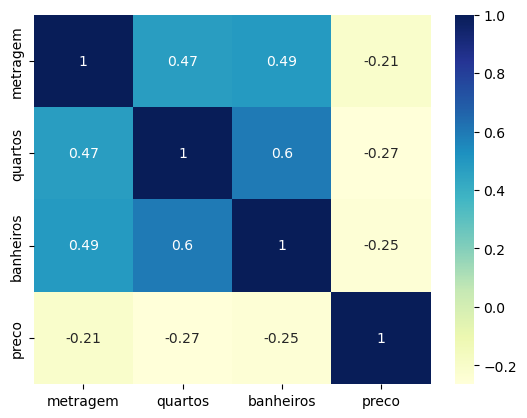

In [241]:
correlacao = nova_tabela.corr()
print(correlacao)
sns.heatmap(correlacao, cmap='YlGnBu', annot=True)
plt.show()


# refatorar o código pensando nas seguintes implementações:
    # verificar quantas páginas de navegação tem disponível para cada bairro e percorrer cada página raspando os dados
    
    # implementar um método para verificar se o captcha apareceu:
        # implementar alguma solução que não quebre o código:
            # tente criar uma interligência artifical capaz de passar pelo captcha ( <- não muito importante por enquanto)